In [267]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import pandas as pd
from keras.utils import np_utils
%matplotlib inline

## Logic Based FizzBuzz Function [Software 1.0]

In [268]:
# Code in software 1.0 using logical approach.
def fizzbuzz(n):
    
    # Logic Explanation. If the modulo operator is applied to the input(integer), we get a reminder. If this reminder is 0, we can say that the input is divisible by 3,5 or 3and5. If it does not satisfy any of the modulo operations, then we return Other.
    if n % 3 == 0 and n % 5 == 0:
        return 'FizzBuzz'
    elif n % 3 == 0:
        return 'Fizz'
    elif n % 5 == 0:
        return 'Buzz'
    else:
        return 'Other'


## Create Training and Testing Datasets in CSV Format

In [269]:
'''THis function in fizzbuzz is used to create csv files, that is later fed to the model for training.
   We use this function to create 3 csv files. In input csv file, we have two fields, imputs and the label. '''

def createInputCSV(start,end,filename):
    
    ''' Lists in python are easily traversable and simple to access, and input data is a collection of bit(binary)
    and the output data has four possible outputs.So to store them, we need lists (which is similar to an array)'''
    inputData   = []
    outputData  = []
    
    '''Why do we need training Data? Training Data is required to train the model. In this, we label all
    the data for the model to train. Basically we are pairing the input(numbers) with the expected output'''
    for i in range(start,end):
        inputData.append(i)
        outputData.append(fizzbuzz(i))
    
    ''' Why Dataframe? Dataframe is a 2D data structure. So here it helps us to store input and label in 2 columns,
    where each input corresponds to a label. Dataframe provides many operations and attributes to manipulate data.'''
    dataset = {}
    dataset["input"]  = inputData
    dataset["label"] = outputData
    
    # Writing to csv 
    pd.DataFrame(dataset).to_csv(filename)
    
    print(filename, "Created!")

## Processing Input and Label Data

In [270]:
def processData(dataset):
    
    ''' Why do we have to process? Data must be processed to make it more usable and informative. 
    Raw data cannot be fed into the machine directly. We won't get expected output from the model if the 
    data is not processed '''
    data   = dataset['input'].values
    labels = dataset['label'].values
    
    processedData  = encodeData(data)
    processedLabel = encodeLabel(labels)
    
    return processedData, processedLabel

In [271]:
import numpy as np

def encodeData(data):
    
    processedData = []
    
    for dataInstance in data:
        
        # Why do we have number 10? For the number of bits to feed to the input layer.
        # 10 bits are required for the neurons (input layer).
        processedData.append([dataInstance >> d & 1 for d in range(10)])
    
    return np.array(processedData)

In [272]:
#Function to fit values to label field, to process data. As we have 4 different outputs, so we have 4 labels.
def encodeLabel(labels):
    
    processedLabel = []
    
    for labelInstance in labels:
        if(labelInstance == "FizzBuzz"):
            # Fizzbuzz
            processedLabel.append([3])
        elif(labelInstance == "Fizz"):
            # Fizz
            processedLabel.append([1])
        elif(labelInstance == "Buzz"):
            # Buzz
            processedLabel.append([2])
        else:
            # Other
            processedLabel.append([0])

    return np_utils.to_categorical(np.array(processedLabel),4)

In [273]:
# Create datafiles
createInputCSV(101,1001,'training.csv')
createInputCSV(1,101,'testing.csv')

training.csv Created!
testing.csv Created!


In [274]:
# Read Dataset, Using the pandas library to read the csv and store them in variables, which are further sent for processing
trainingData = pd.read_csv('training.csv')
testingData  = pd.read_csv('testing.csv')

# Process Dataset
processedTrainingData, processedTrainingLabel = processData(trainingData)
processedTestingData, processedTestingLabel   = processData(testingData)

## Tensorflow Model Definition

In [275]:
# Defining Placeholder. Placeholders are using to allocate variables
inputTensor  = tf.placeholder(tf.float32, [None, 10])
outputTensor = tf.placeholder(tf.float32, [None, 4])

In [276]:
# Defining the number of hidden neurons in the hidden layer.
NUM_HIDDEN_NEURONS_LAYER_1 = 100
LEARNING_RATE = 0.055
training_L=[]

# Initializing the weights to Normal Distribution. THis is where all the weights are intialized to the tensor.
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape,stddev=0.01))

# Initializing the input to hidden layer weights, There are 10 inputs and we mention the number of hidden layers.
#input hidden weights, are the weights betweent the input and hidden layers
input_hidden_weights  = init_weights([10, NUM_HIDDEN_NEURONS_LAYER_1])
# Initializing the hidden to output layer weights
hidden_output_weights = init_weights([NUM_HIDDEN_NEURONS_LAYER_1, 4])

# Computing values at the hidden layer. We are using ReLu as it is computationally less expensive and, our dataset does not involve negative numbers.
hidden_layer = tf.nn.relu(tf.matmul(inputTensor, input_hidden_weights))
# Computing values at the output layer. We get output by multiplying all the tensors(weights) from the hidden layer
output_layer = tf.matmul(hidden_layer, hidden_output_weights)

#loss=tf.nn.softmax_cross_entropy_with_logits(logits=output_layer, labels=outputTensor).eval(feed_dict)

# Defining Error Function. This function describes the mean of error between the expected probability distribution and the original probability distribution
#Softmax takes a tensor and converts it into a tensor of real numbers between the range of (0,1)
error_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_layer, labels=outputTensor))

#fn=tf.map_fn(tf.nn.softmax_cross_entropy_with_logits(logits=output_layer, labels=outputTensor), epochs)
#with tf.Session() as sess:
    #print(sess.run(fn))

# Defining Learning Algorithm and Training Parameters. In order for the weights to be set correctly, so that we get expected outputs,
# we have to use an optimizing algorithm, which changes the weights thereby minimizing the error.

training_GD = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(error_function)
training_Adam= tf.train.AdamOptimizer(LEARNING_RATE).minimize(error_function)
training_RMS= tf.train.RMSPropOptimizer(LEARNING_RATE).minimize(error_function)


# Prediction The prection of an input can be found by the largest value. THis is done by the argmax function.
prediction = tf.argmax(output_layer, 1)

# Training the Model

In [277]:
NUM_OF_EPOCHS = 5000
BATCH_SIZE = 100

training_accuracy = []

#session is used to run tensorflow operations and it initiates the tensorflow object
with tf.Session() as sess:
    
    ''' Set Global Variables ? All variables are initialized using this function.
     Before you can use a variable, it must be initialized. So in the current fizzbuzz program that is the 
     tensorflow model definition, we are returning variable to set the weights for input, hidden and output layers.
     This line of code, initializes all these variables in the session, thereby setting weights. If this is not done
     , there won't be any values for the model to train'''
    tf.global_variables_initializer().run()
    
    
    a=[]
    b=[]
    c=[]

    
    for epoch in tqdm_notebook(range(NUM_OF_EPOCHS)):
        total_GD=0
        
        #Shuffle the Training Dataset at each epoch. This is required in order to
        p = np.random.permutation(range(len(processedTrainingData)))
        processedTrainingData  = processedTrainingData[p]
        processedTrainingLabel = processedTrainingLabel[p]
        total=0
    
        # Start batch training. Cannot train the whole batch at once, the reason why batch size is used.
        #run function is used to start the tensorflow session
        for start in range(0, len(processedTrainingData), BATCH_SIZE):
            end = start + BATCH_SIZE
            _,cost_GD=sess.run((training_GD, error_function),feed_dict={inputTensor: processedTrainingData[start:end], 
                                          outputTensor: processedTrainingLabel[start:end]})
            '''cost_Adam=sess.run((training_Adam,error_function),feed_dict={inputTensor: processedTrainingData[start:end], 
                                          outputTensor: processedTrainingLabel[start:end]})
            cost_Ada=sess.run((training_Ada,error_function),feed_dict={inputTensor: processedTrainingData[start:end], 
                                          outputTensor: processedTrainingLabel[start:end]})'''
            # adding up the cost
            total_GD+=cost_GD
            
            '''total_Adam+=cost_Adam[1]
            total_Ada+=cost_Ada[1]'''
               
    # Training accuracy for an epoch
        # creating a new list and appending the number, which is the sum of costs per batch. This happens for each epoch.
        a.append(total_GD/BATCH_SIZE)
        training_accuracy.append(np.mean(np.argmax(processedTrainingLabel, axis=1) ==
                             sess.run(prediction, feed_dict={inputTensor: processedTrainingData,
                                                             outputTensor: processedTrainingLabel})))
    
        
    
    
    # Testing. The predicted output is required to be test against the test file. 
    predictedTestLabel = sess.run(prediction, feed_dict={inputTensor: processedTestingData})

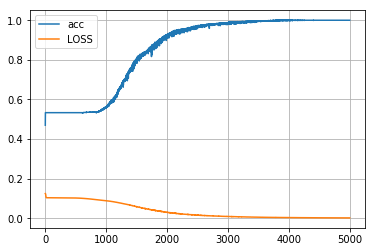

In [278]:
df = pd.DataFrame()
#df['LOSS']= a
df['acc'] = training_accuracy
df['LOSS'] = a

#df['epochs']= NUM_OF_EPOCHS
df.plot(grid=True, legend=True)

In [279]:
def decodeLabel(encodedLabel):
    if encodedLabel == 0:
        return "Other"
    elif encodedLabel == 1:
        return "Fizz"
    elif encodedLabel == 2:
        return "Buzz"
    elif encodedLabel == 3:
        return "FizzBuzz"

# Testing the Model [Software 2.0]

In [280]:
#Testing is done against the test.csv
wrong   = 0
right   = 0

predictedTestLabelList = []
""
for i,j in zip(processedTestingLabel,predictedTestLabel):
    predictedTestLabelList.append(decodeLabel(j))
    
    if np.argmax(i) == j:
        right = right + 1
    else:
        wrong = wrong + 1

print("Errors: " + str(wrong), " Correct :" + str(right))

print("Testing Accuracy: " + str(right/(right+wrong)*100))

# Please input your UBID and personNumber 
testDataInput = testingData['input'].tolist()
testDataLabel = testingData['label'].tolist()

testDataInput.insert(0, "UBID")
testDataLabel.insert(0, "sanand3")

testDataInput.insert(1, "personNumber")
testDataLabel.insert(1, "50291478")

predictedTestLabelList.insert(0, "")
predictedTestLabelList.insert(1, "")

output = {}
output["input"] = testDataInput
output["label"] = testDataLabel

output["predicted_label"] = predictedTestLabelList

opdf = pd.DataFrame(output)
opdf.to_csv('output.csv')

Errors: 7  Correct :93
Testing Accuracy: 93.0


In [235]:
#GRAPHs





